In [34]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Introduction to AI and OpenVino

## Session 03a - Classification

###  Part 1: Supervised Machine Learning Algorithms

<img src='../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [35]:
###------------------
### Import statements
###------------------

import sys
import os
from time import time
import numpy as np
import pandas as pd

from sklearn.datasets import load_digits, make_blobs, load_breast_cancer, load_iris
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import seaborn as sns
import matplotlib.pyplot as plt
from cycler import cycler

In [36]:
# Some Basic Parameters for housekeeping

# set location of input files:
inpDir = os.path.join('..', '..', 'input')

# set location of inputs for this module
moduleDir = 'machine_learning'

# set location of output files
outDir = os.path.join('..', 'output')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }

CMAP = plt.cm.rainbow
plt.rcParams.update(params);
plt.set_cmap(CMAP);


TEST_SIZE = 0.25

<Figure size 1500x600 with 0 Axes>

In [37]:
def fn_plot_decision_boundary(pred_func, X, y, ax = None):
    '''
        Attrib:
           pred_func : function based on predict method of 
                    the classifier
           X : feature matrix
           y : targets
       Return:
           None
    '''
    if ax is None:
        ax = plt.gca()
        
    # Set min and max values and give it some padding
    xMin, xMax = X[:, 0].min() - .05, X[:, 0].max() + .05
    yMin, yMax = X[:, 1].min() - .05, X[:, 1].max() + .05
    
    # grid size for mesh grid
    h = 0.05
    
    # Generate a grid of points with distance 'h' between them
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))
    
    # Predict the function value for the whole grid
    Z = pred_func.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Make its shape same as that of xx 
    Z = Z.reshape(xx.shape)
    
    # Now we have Z value corresponding to each of the combination of xx and yy
    # Plot the contour and training examples
    ax.contourf(xx, yy, Z, cmap=CMAP, alpha = 0.6)
    
    # plot the points as well
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=CMAP, edgecolors='black')

## Naive Bayes

P(X|Y) = $\frac{P(Y|X)P(Y)}{P(X)}$

<div>
<img src = '../../images/iris.png' width='600 px' align ='left'>
<img src = '../../images/iris_petal_sepal.png' width='300 px',  align ='right'>
</div>


<hr>

### DataSet
1. Number of Instances: 150 (50 in each of three classes)
2. Number of Attributes: 4 numeric, predictive attributes and the class
3. Attribute Information:

   a. sepal length in cm
   
   b. sepal width in cm
   
   c. petal length in cm
   
   d. petal width in cm
   
   e. class:
      - Iris Setosa
      - Iris Versicolour
      - Iris Virginica
      
      
4. Missing Attribute Values: None
5. Class Distribution: 33.3% for each of 3 classes.


## Loading from CSV

>iris_df = pd.read_csv(iris_file, sep=',', skiprows=1, header=None, names = iris_features)

In [38]:
# Note the time of starting
t0= time()


# CSV file name
iris_file = os.path.join(inpDir, moduleDir, 'iris.csv')

# Define feature names

iris_features = ['sepal length',
                 'sepal width',
                 'petal length',
                 'petal width',
                 'target']
# Read the CSV file
iris_df = pd.read_csv(iris_file, sep=',', skiprows=1, 
                      header=None, names = iris_features)

print ("Read CSV file of shape {} at:{:7.3f} Sec".format(iris_df.shape, (time()-t0)),
           flush = True)

Read CSV file of shape (150, 5) at:  0.001 Sec


In [39]:
iris_df.head()

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


## Feature Extraction

Extract features and labels from the dataframe.

**Remember:** We can use only numerical values in the features and labels. Incidentally, Iris dataset contains numerical values only.

In [40]:
features = iris_df.drop('target',axis=1).to_numpy()
labels = iris_df['target']

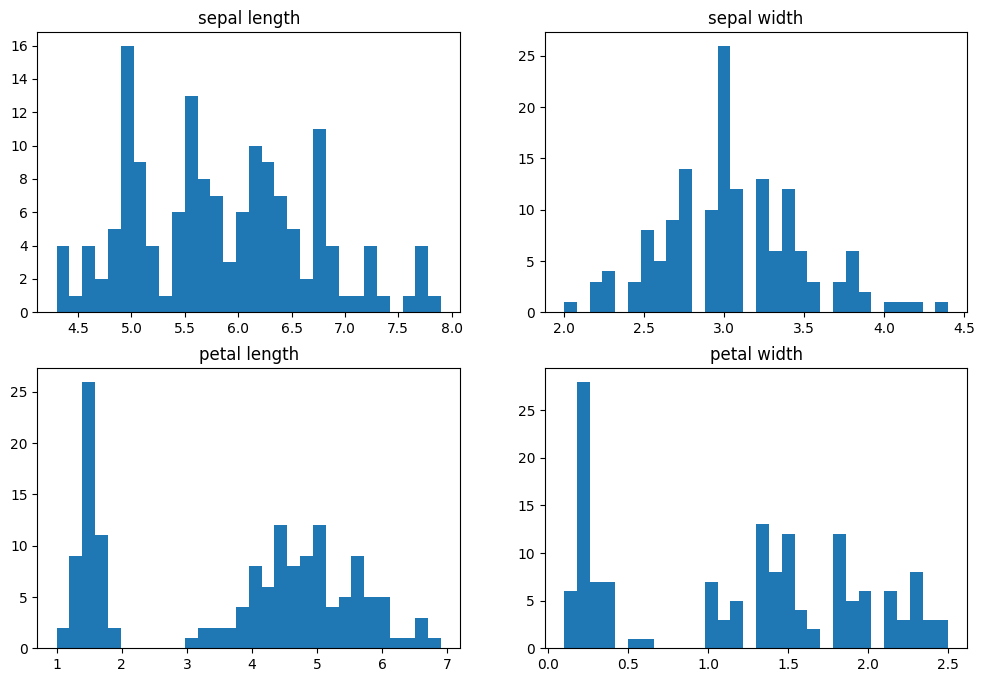

In [41]:
# Plot the features
plt.figure( figsize = (12 , 8) )

for ii in range (features.shape[1]):
    
        plt.subplot(2, 2, ii+1 ) # subplot for each of the column
                
        plt.subplots_adjust(wspace=0.2, hspace=0.2)
        
        n, bins, patches = plt.hist( features [ :, ii], 30)
        
        plt.title('{}'.format(iris_features[ii]))
        
        plt.axis('tight')
        
        #plt.legend(loc = 'best')
plt.show()

## Classifier

$Initialization \rightarrow fit \rightarrow predict$

In [42]:
#Make predictions using Gaussian Naive Bayes

from sklearn.naive_bayes import GaussianNB

# instantiate
clf = GaussianNB()

# fit the classifier
clf.fit(features, labels)

# make predictions
y_pred = clf.predict(features)

In [43]:
# Some helpers to format the plot

target_names = ['setosa','versicolor','virginica']

# this formatter will label the colorbar with the correct target names
formatter = plt.FuncFormatter(lambda i, *args: target_names[int(i)])

In [44]:
# Let's use first two columns of the data and plot the data to visualize the results
xplot = iris_df.keys()[0]

yplot = iris_df.keys()[1]


# also locate instances which are incorrectly predicted.
x_err = iris_df[xplot][(labels != y_pred)]
y_err = iris_df[yplot][(labels != y_pred)]

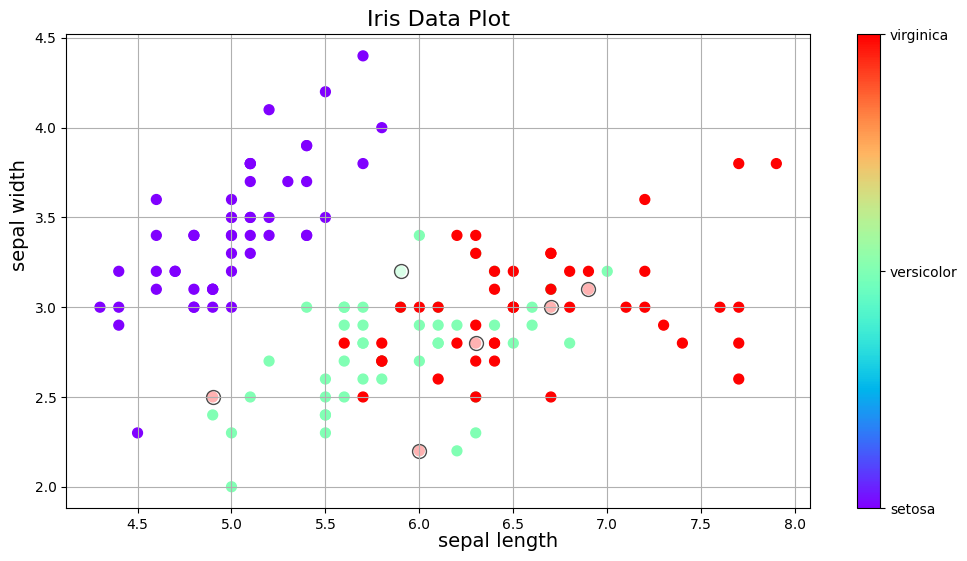

In [45]:
# Plot the data points

# Create a figure of given size
fig = plt.figure(figsize=(12,6))

# Add a subplot
ax = fig.add_subplot(111)

# Set title
title = 'Iris Data Plot'

plt.scatter( iris_df[xplot], iris_df[yplot], s = 50, 
            c = iris_df['target']) # , cmap=plt.cm.brg

plt.colorbar(ticks=[0, 1, 2], format=formatter)

plt.scatter(x_err, y_err, color = "w", label="mismatch", 
            s = 100, alpha = 0.7, edgecolor = 'black')

# Grid lines inside plot can be set as True or False
ax.grid(True)

# Plot frame can be set as true or false
ax.set_frame_on(True)

 
# Customize title, set position, allow space on top of plot for title
ax.set_title(title, fontsize=16, ha='center')

plt.subplots_adjust(top=0.9)

ax.title.set_position((0.5,1))

# Set x axis label
ax.xaxis.set_label_position('bottom')

ax.set_xlabel(xplot, fontsize=14,  ha='left') 

ax.xaxis.set_label_coords(0.5, -0.05)

# Set y axis label
ax.set_ylabel(yplot, fontsize=14,  ha='left') 

plt.show()

In [46]:
iris_correct = iris_df[(labels == y_pred)]


accuracy = (iris_correct.shape[0]/iris_df.shape[0])

print ("We have predicted {:d} points correctly out of {:d} points".format (
        iris_correct.shape[0],iris_df.shape[0] ))

print ("Hence, the accuracy is {:5.3f}".format(accuracy))

We have predicted 144 points correctly out of 150 points
Hence, the accuracy is 0.960


We can also use `sklearn` built-in function to calculate accuracy.

In [47]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(labels, y_pred)

print ("The accuracy is {:5.3f}".format(accuracy))

The accuracy is 0.960


## Linear models for classification

Linear models are also extensively used for classification. 

A prediction is made using the following formula:

$\hat{y} = w_{0}*x_{0} + w_{1}*x_{1} + ... + w_{p}*x_{p} + b > 0$

Now instead of just returning the weighted sum of the features, we threshold the predicted value at zero. If the function is smaller than zero, we predict the class –1; if it is larger than zero, we predict the class +1.

The two most common linear classification algorithms are **logistic regression** and linear **support vector machines
(linear SVMs)**.

Despite its name, logistic regression is a classification algorithm and not a regression algorithm, and it should not be confused with linear Regression.

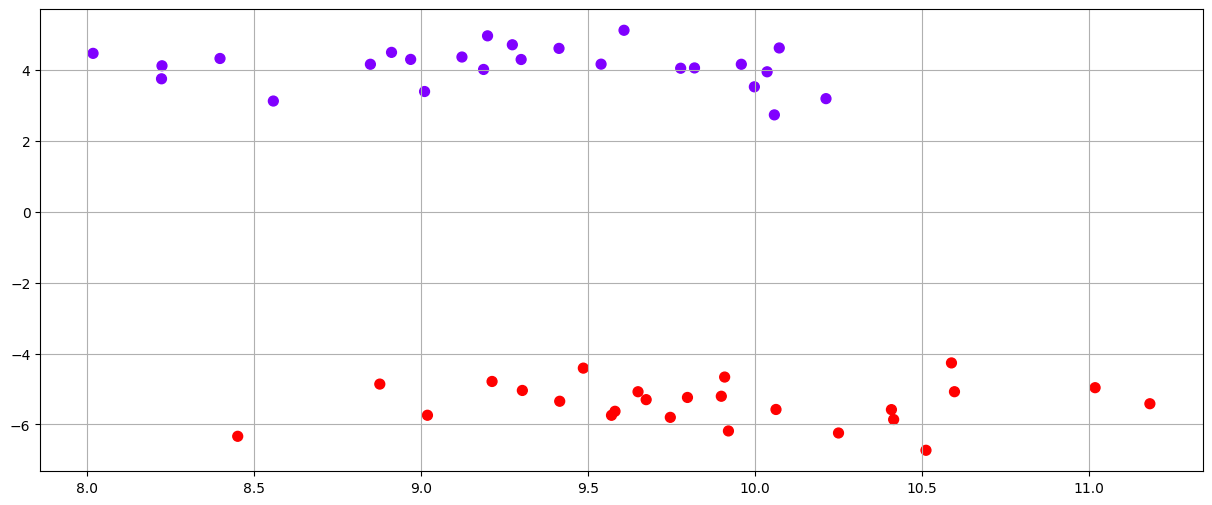

In [48]:
# Lets prepare some data
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=50, centers=2,
                  random_state=RANDOM_STATE, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50);
plt.grid()

In [49]:
def fn_plot_decision_function(classifier, 
                                     X, 
                                     fill=True, 
                                     ax=None, 
                                     eps=None, 
                                     alpha=1,
                                     cm=CMAP,
                                     linewidth=None, 
                                     threshold=None,
                                     linestyle="solid"):
    # binary?
    if eps is None:
        eps = X.std() / 2.

    if ax is None:
        ax = plt.gca()

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 1000)
    yy = np.linspace(y_min, y_max, 1000)

    X1, X2 = np.meshgrid(xx, yy)
    
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    
    if hasattr(classifier, "decision_function"):
        decision_values = classifier.decision_function(X_grid)
        levels = [0] if threshold is None else [threshold]
        fill_levels = [decision_values.min()] + levels + [
            decision_values.max()]
    else:
        # no decision_function
        decision_values = classifier.predict_proba(X_grid)[:, 1]
        levels = [.5] if threshold is None else [threshold]
        fill_levels = [0] + levels + [1]
    if fill:
        ax.contourf(X1, X2, decision_values.reshape(X1.shape),
                    levels=fill_levels, alpha=alpha, cmap=cm)
        
    else:
        ax.contour(X1, X2, decision_values.reshape(X1.shape), levels=levels,
                   colors="black", alpha=alpha, linewidths=linewidth,
                   linestyles=linestyle, zorder=5)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

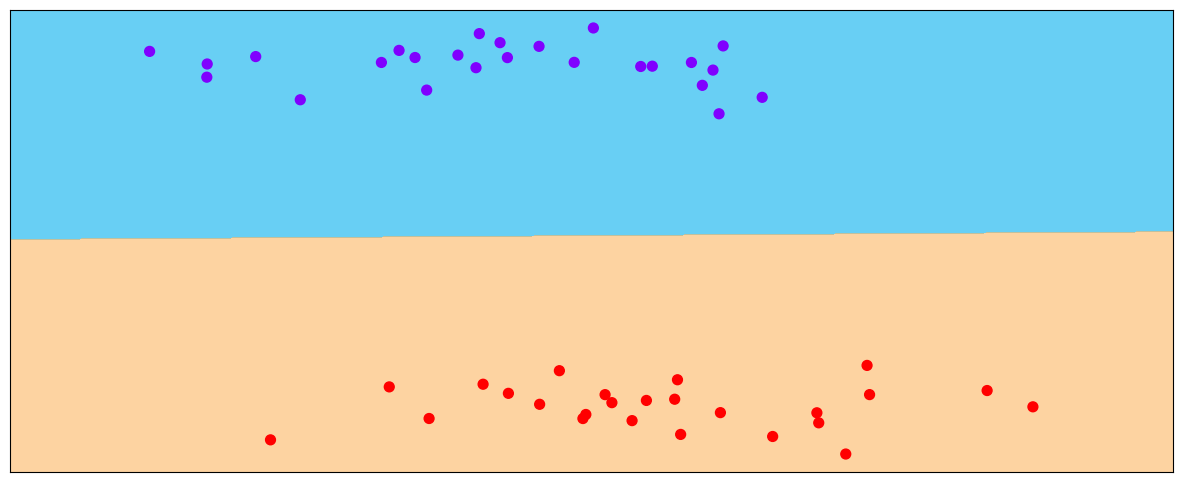

In [50]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X,y)
fn_plot_decision_function(clf, X, fill=True, alpha = 0.6, eps= 0.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50);

## Support Vector Machines

The line that maximizes the minimum margin.

The model class of 'hyper-planes with a margin of m' has a low VC dimension if m is big.
This maximum-margin separator is determined by a subset of the datapoints.
Datapoints in this subset  are called “support vectors”.
It will be useful computationally if only a small fraction of the datapoints are support vectors, because we use the support vectors to decide which side of the separator a test case is on.

In [51]:
#Make predictions using Support Vector Machines
from sklearn.svm import SVC
clf = SVC(kernel='linear')

X, y = make_blobs(n_samples=50, centers=2,
                  random_state=RANDOM_STATE, cluster_std=0.60)

clf.fit(X,y)

SVC(kernel='linear')

In [52]:
def fn_plot_svc_decision_function(clf):
    
    """Plot the decision function for a 2D SVC"""
    
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    
    Y, X = np.meshgrid(y, x)
    
    P = np.zeros_like(X)
    
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function(np.array([xi, yj]).reshape(1, -1)).item()
    return plt.contour(X, Y, P, colors='k',
                       levels=[-1, 0, 1],
                       linestyles=['--', '-', '--'])

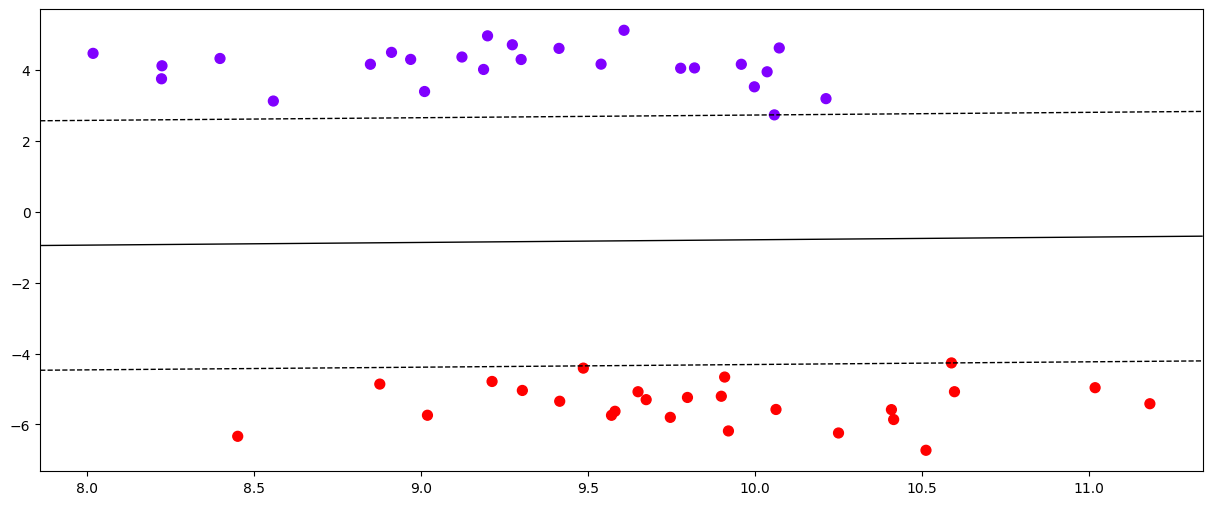

In [53]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50)
fn_plot_svc_decision_function(clf);

Notice that the dashed lines touch a couple of the points: these points are known as the "support vectors", and are stored in the ``support_vectors_`` attribute of the classifier:

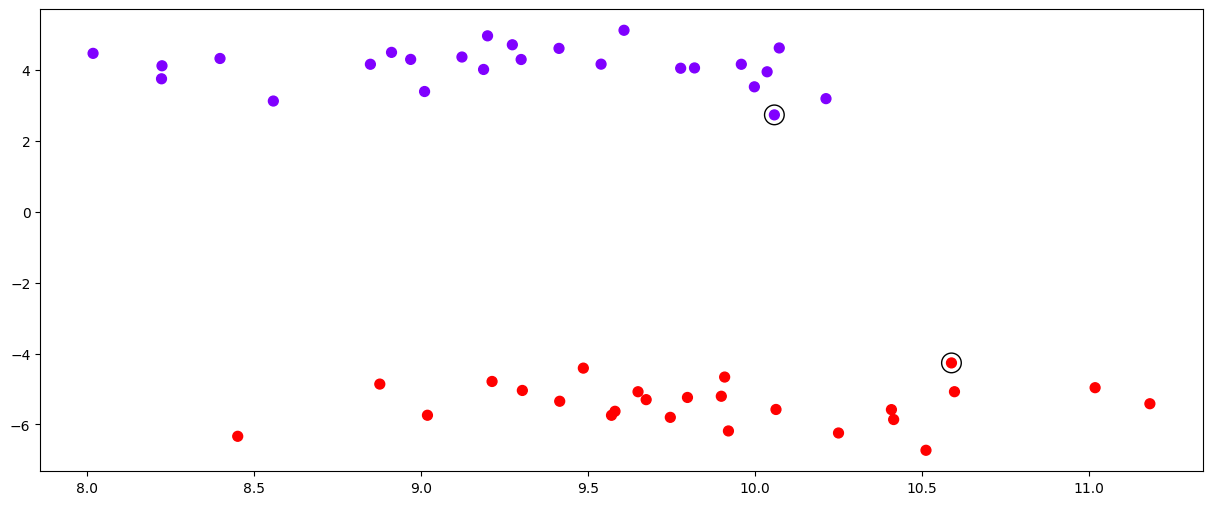

In [54]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50)

plt.scatter(clf.support_vectors_[:, 0], 
            clf.support_vectors_[:, 1],
            s=200, edgecolors='k', facecolor = 'none');

The unique thing about SVM is that **only the support vectors matter**; that is, if you moved any of the other points without letting them cross the decision boundaries, they would have no effect on the classification results!

This may seem like a trivial task, but it is a simple version of a very important concept. By drawing this separating line, we have learned a model which can **generalize** to new data. If you were to drop another point onto the plane which is unlabeled, this algorithm could now **predict** whether it's a blue or a red point.

So far we have used a linear kernel; it is also possible to use *radial basis function* kernels as well as others.

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])
SVC: kernel : linear  | F1 Score :  0.9801
SVC: kernel : rbf     | F1 Score :  0.9844
SVC: kernel : poly    | F1 Score :  0.9889


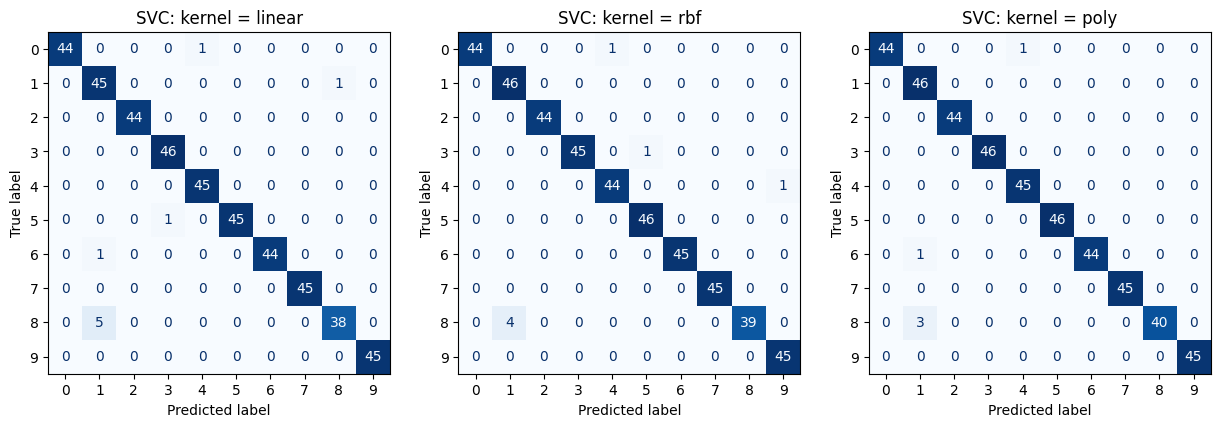

In [55]:
digits = load_digits()

print(digits.keys())

X_train, X_test, y_train, y_test = train_test_split(
    digits.data, 
    digits.target, 
    stratify=digits.target, 
    random_state=RANDOM_STATE)

fig, axes = plt.subplots(1,3, figsize = (15,8))

for i, kernel in enumerate(['linear', 'rbf', 'poly']):
    clf = SVC(kernel=kernel).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("SVC: kernel : {: <7}".format(kernel), end = ' | ')
    print("F1 Score : {: .4f}".format(f1_score(y_test, y_pred, average='weighted')))
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=digits.target_names)

    disp.plot(ax = axes[i], cmap=plt.cm.Blues, colorbar=False);
    axes[i].set_title("SVC: kernel = {0}".format(kernel))
    axes[i].grid(False)
plt.show()

### Kernelized Support Vector Machines
#### Linear Models and Non-linear Features

In [56]:
X, y = make_blobs(centers=4, random_state=RANDOM_STATE)
y = y % 2

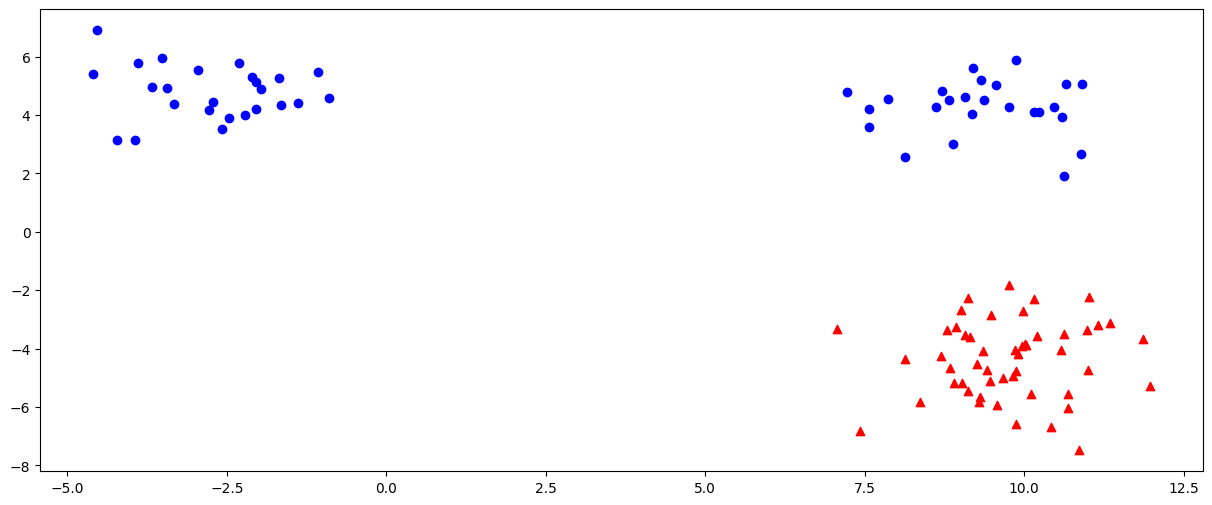

In [57]:
fig, ax = plt.subplots()

mask = y == 0

ax.scatter(X[mask,0], X[mask,1], c = 'b')
ax.scatter(X[~mask,0], X[~mask,1], c = 'r', marker='^')

plt.show()

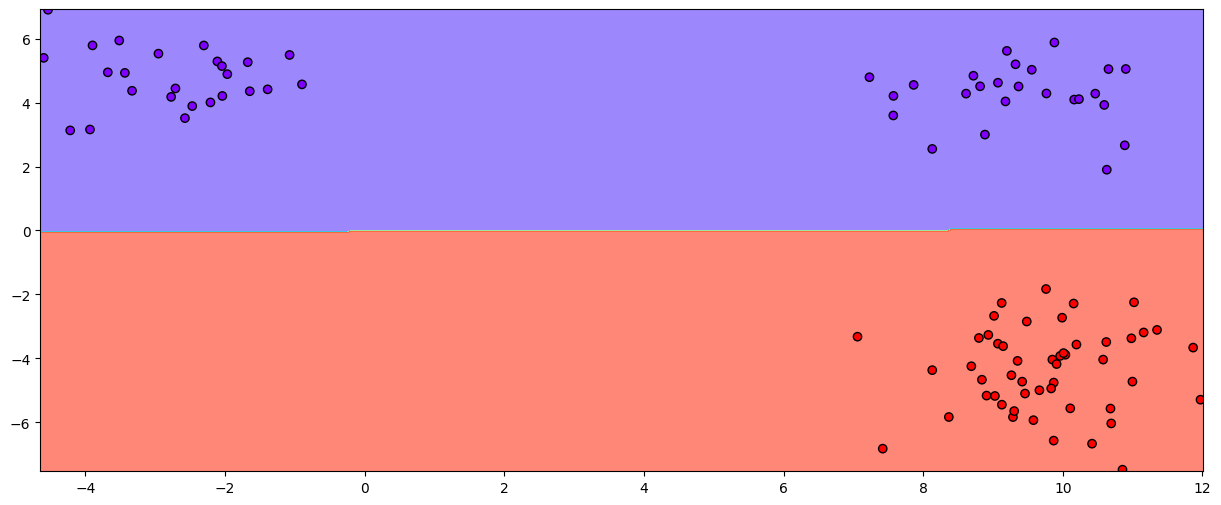

In [58]:
linear_svm = LinearSVC(dual='auto', random_state=RANDOM_STATE).fit(X, y)

fn_plot_decision_boundary(linear_svm, X, y)

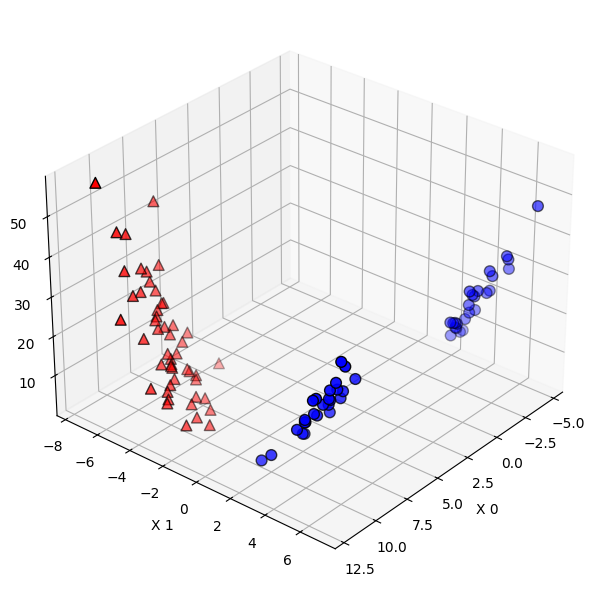

In [59]:
# add the squared first feature
X_new = np.hstack([X, X[:, 1:] ** 2])

from mpl_toolkits.mplot3d import Axes3D, axes3d

ax = plt.figure().add_subplot(projection='3d')

# plot first all the points with y==0, then all with y == 1
mask = y == 0

ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b', s=60, edgecolor='k')

ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^', s=60, edgecolor='k')

ax.set_xlabel("X 0")

ax.set_ylabel("X 1")

ax.set_zlabel("X 1 ** 2")

# change the view point
ax.view_init(elev=30, azim=40, roll=0);

plt.tight_layout()

plt.show()

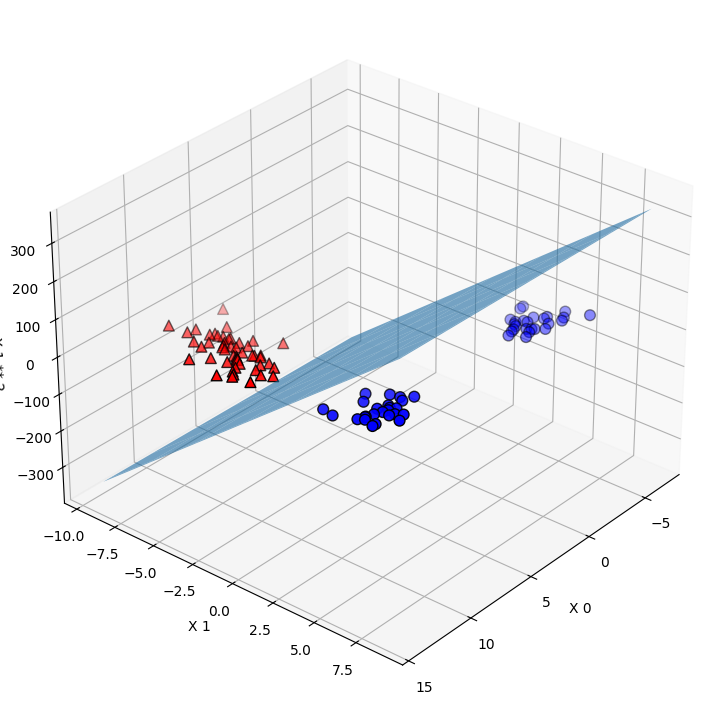

In [60]:
linear_svm_3d = LinearSVC(random_state=RANDOM_STATE, dual='auto').fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

# show linear decision boundary
ax = plt.figure(figsize=(9,9)).add_subplot(projection='3d')

xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)

XX, YY = np.meshgrid(xx, yy)

ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]

ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.6)

ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b', s=60, edgecolor='k')

ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
         s=60, edgecolor='k')

ax.set_xlabel("X 0")

ax.set_ylabel("X 1")

ax.set_zlabel("X 1 ** 2")

# change the view point
ax.view_init(elev=30, azim=40, roll=0);

## Using IRIS Dataset

In [62]:
target_names = ['setosa','versicolor','virginica']

# this formatter will label the colorbar with the correct target names
formatter = plt.FuncFormatter(lambda i, *args: target_names[int(i)])

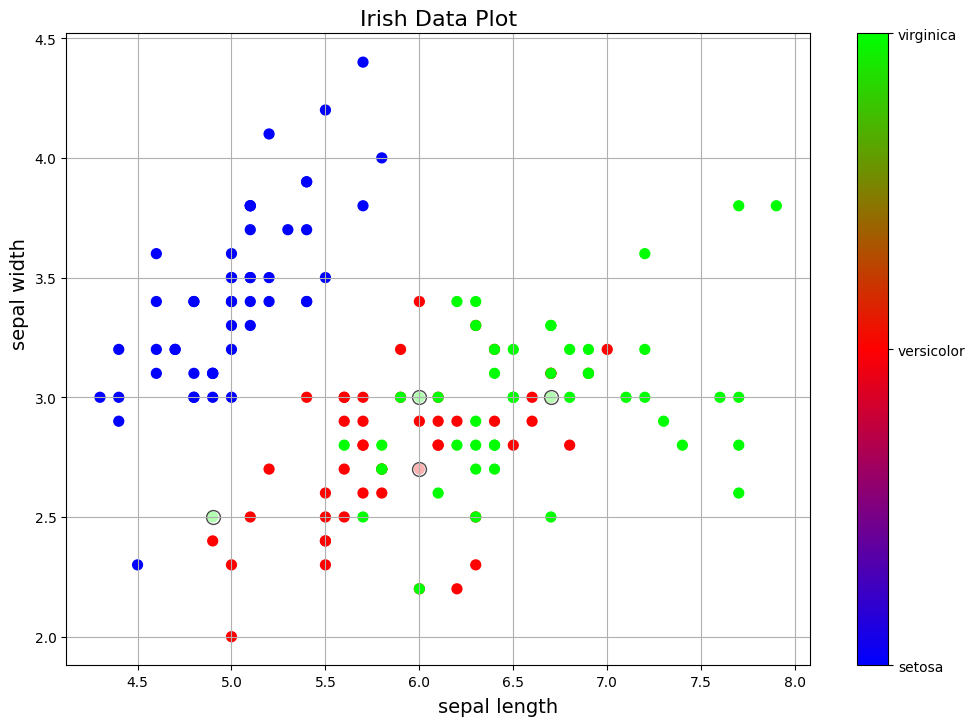

In [63]:
# Retrain our classifier on full data set
clf = SVC(kernel='rbf')
clf.fit(features, labels)

y_pred = clf.predict(features)

# Create a figure of given size
fig = plt.figure(figsize=(12,8))

# Add a subplot
ax = fig.add_subplot(111)

# Set title
title = 'Irish Data Plot'
xplot = iris_df.keys()[0]
yplot = iris_df.keys()[1]

# also locate the errors in prediction
x_err = iris_df[xplot][(labels != y_pred)]
y_err = iris_df[yplot][(labels != y_pred)]

plt.scatter( iris_df[xplot], iris_df[yplot], s= 50, c=iris_df['target'], cmap=plt.cm.brg)
plt.colorbar(ticks=[0, 1, 2], format=formatter)
plt.scatter(x_err, y_err, color = "w", label="mismatch", s = 100, alpha=0.7, edgecolor = 'black')

# Grid lines inside plot can be set as True or False
ax.grid(True)

# Plot frame can be set as true or false
ax.set_frame_on(True)

 # Customize title, set position, allow space on top of plot for title
ax.set_title(title, fontsize=16, ha='center')
plt.subplots_adjust(top=0.9)
ax.title.set_position((0.5,1))

# Set x axis label
ax.xaxis.set_label_position('bottom')
ax.set_xlabel(xplot, fontsize=14,  ha='left') 
ax.xaxis.set_label_coords(0.5, -0.05)

# Set y axis label
ax.set_ylabel(yplot, fontsize=14,  ha='left') 

plt.show()

## Parameter Tuning
Support vector Machines have a number of tunable parameters. Frequently used ones are :
- Kernel
- C
- Gamma

So, far we have used only kernal = 'linear' which uses “one-against-one” approach (Knerr et al., 1990). Other kernals are ‘poly’, ‘rbf(Radial Basis Function)’, ‘sigmoid’, ‘precomputed’ or a callable. If none is given, ‘rbf’ will be used..

In [69]:
# For convenience, create a function to plot
def plot_hyplane(classifier, features, labels, i):
    plt.subplot(1, 3, i )
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    pred = classifier.predict(features)
    
    x_min, x_max = features[:, 0].min() - .1, features[:, 0].max() + .1
    y_min, y_max = features[:, 1].min() - .1, features[:, 1].max() + .1

    xx, yy = np.meshgrid ( np.linspace ( x_min, x_max, 1000 ),
                       np.linspace ( y_min, y_max, 1000))
    Z = classifier.predict ( np.c_[ xx.ravel(), yy.ravel()])

    # Plot the decision surface
    Z = Z.reshape( xx.shape )
    plt.grid(False)
    plt.pcolormesh(xx, yy, Z, cmap = plt.cm.Set3 ) # refer http://matplotlib.org/users/colormaps.html

    # Plot also the training points
    plt.scatter( features [ :, 0], features [ :, 1], c = labels, s = 5,
            cmap=plt.cm.flag)

    plt.axis('tight')

### PCA

*PCA will be discussed in detail.*

No of features are not very high, we may have used it as it is. However for ease of plotting, let's reduce the features to 2.

In [70]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features)

### C Value : Penalty parameter
A hyperplane separating all classes can lead to poorly fit models especially if there are unusual cases. C allows for some examples to be "ignored" or placed on the wrong side of the hyperplane.
- Large C $\rightarrow$ low bias and high variance.
- Small C $\rightarrow$ higher bias and lower variance.

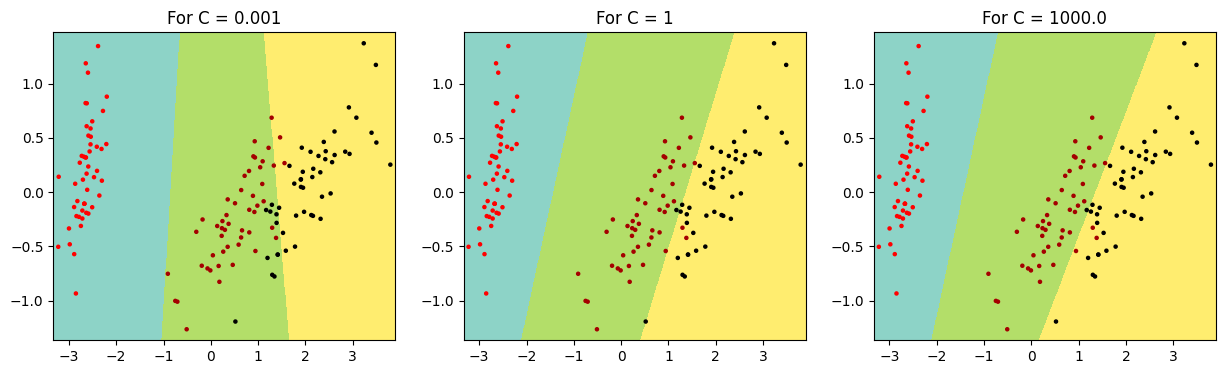

In [71]:
plt.figure( figsize = (15,4) )
C_values = [1e-3, 1, 1e3]

i = 1

for C in C_values:
    clf = SVC(kernel='linear', C = C)
    clf.fit(pca_features, labels)

    plot_hyplane(clf, pca_features, labels, i)
    i +=1
    plt.title('For C = {}'.format(C))
    
#plt.savefig('../images/22_svm_C.jpg')
plt.show()

## Kernel
We will be trying three kernels:
- `Linear` gives linear decision frontiers. It is the most computationally efficient approach and the one that requires the least amount of data.
- `rbf` uses 'radial basis functions' centered at each support vector to assemble a decision frontier. The size of the RBFs, that ultimately controls the smoothness of the decision frontier. RBFs are the most flexible approach, but also the one that will require the largest amount of data.
    -  Radial Kernels behave like a weighted Nearest Neighbor
    -  Closest observation has lot of influence on how we classify new observation
    -  Influence = $e^{\gamma(a-b)}$
- `poly` gives decision frontiers that are polynomial. The order of this polynomial is given by the 'order' argument.

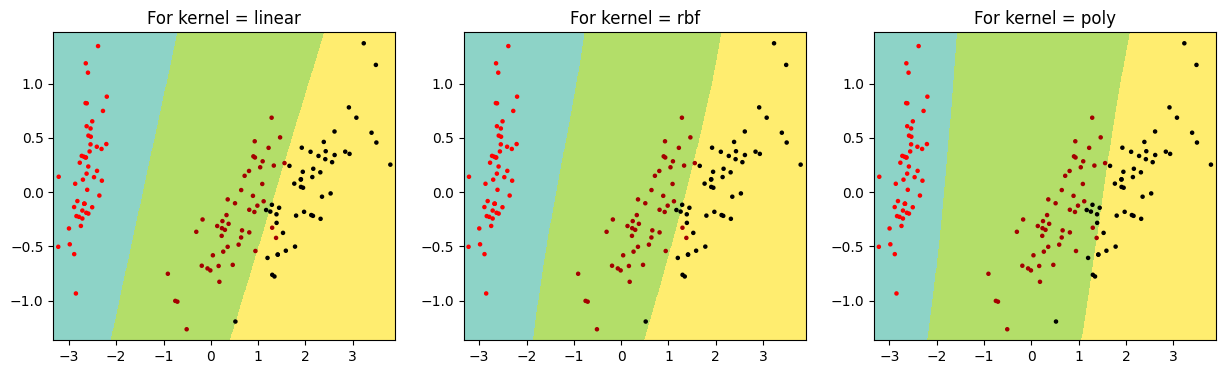

In [72]:
plt.figure( figsize = (15,4) )
kernels = ['linear', 'rbf', 'poly']

i = 1

for k in kernels:
    clf = SVC(kernel=k)
    clf.fit(pca_features, labels)

    plot_hyplane(clf, pca_features, labels, i)
    i +=1
    plt.title('For kernel = {}'.format(k))
    plt.axis('tight')
#plt.savefig('../images/22_svm_kernel.jpg')
plt.show()

## Gamma

- Small gamma $\rightarrow$ sharp curves in the higher dimensions $\rightarrow$low bias and high variance
- Large gamma $\rightarrow$ a smooth curves $\rightarrow$ higher bias and low variance

We will be using three values of **Gamma ; 0.001, 1 and auto**

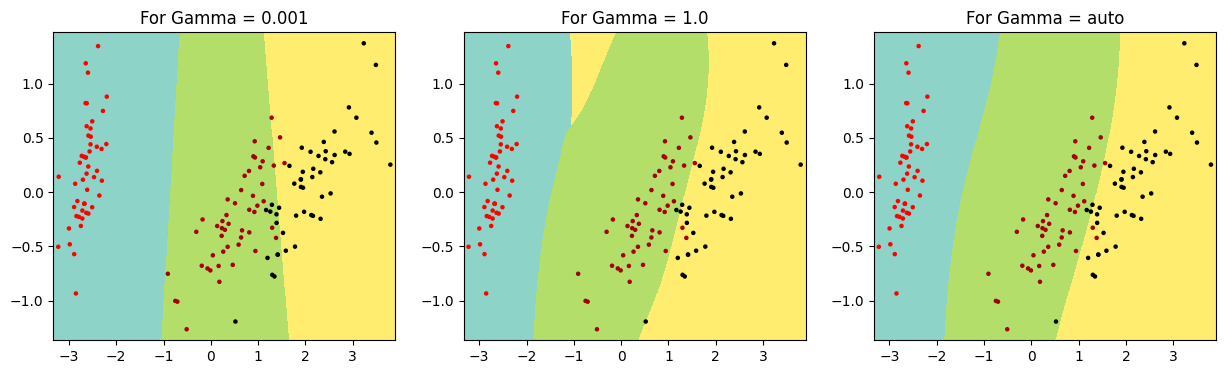

In [73]:
plt.figure( figsize = (15,4) )

gammas = [1e-3, 1.0, 'auto']

i = 1

for g in gammas:
    
    clf = SVC(kernel='rbf', gamma = g)
    
    clf.fit(pca_features, labels)

    plot_hyplane(clf, pca_features, labels, i)
    
    i +=1
    
    plt.title( 'For Gamma = {}'.format(g))
    
    plt.axis('tight')
#plt.savefig('../images/22_svm_gamma.jpg')
plt.show()

## Decision Trees
Decision trees at their root are extremely intuitive.  They encode a series of binary choices in a process that parallels how a person might classify things themselves, but using an information criterion to decide which question is most fruitful at each step.  Its like playing 20-questions game.

For example, if you wanted to create a guide to identifying an animal found in nature, you might ask the following series of questions:

- Is the animal bigger or smaller than a meter long?
    + *bigger*: does the animal have horns?
        - *yes*: are the horns longer than ten centimeters?
        - *no*: is the animal wearing a collar
    + *smaller*: does the animal have two or four legs?
        - *two*: does the animal have wings?
        - *four*: does the animal have a bushy tail?

and so on.  This binary splitting of questions is the essence of a decision tree.

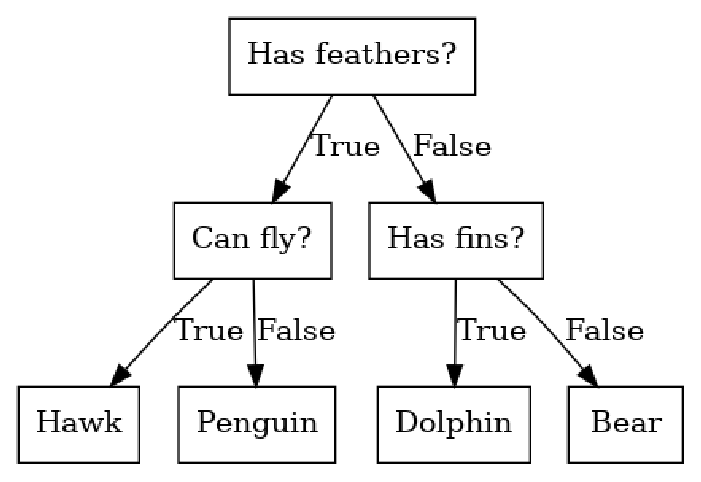

In [74]:
import graphviz

import matplotlib.image as mpimg

#Instantiate the Graph
decision_tree = graphviz.Digraph(node_attr={'shape': 'box'},
                                 edge_attr={'labeldistance': "10.5"},
                                 format="png")

###---------------
### add some nodes
###---------------
decision_tree.node("0", "Has feathers?")

decision_tree.node("1", "Can fly?")

decision_tree.node("2", "Has fins?")

decision_tree.node("3", "Hawk")

decision_tree.node("4", "Penguin")

decision_tree.node("5", "Dolphin")

decision_tree.node("6", "Bear")

###---------------
### add some edges
###---------------
decision_tree.edge("0", "1", label="True")

decision_tree.edge("0", "2", label="False")

decision_tree.edge("1", "3", label="True")

decision_tree.edge("1", "4", label="False")

decision_tree.edge("2", "5", label="True")

decision_tree.edge("2", "6", label="False")

decision_tree.render("images/decision_tree")

fig, ax = plt.subplots()

ax.imshow(mpimg.imread("images/decision_tree.png"))

ax.set_axis_off()

plt.show()

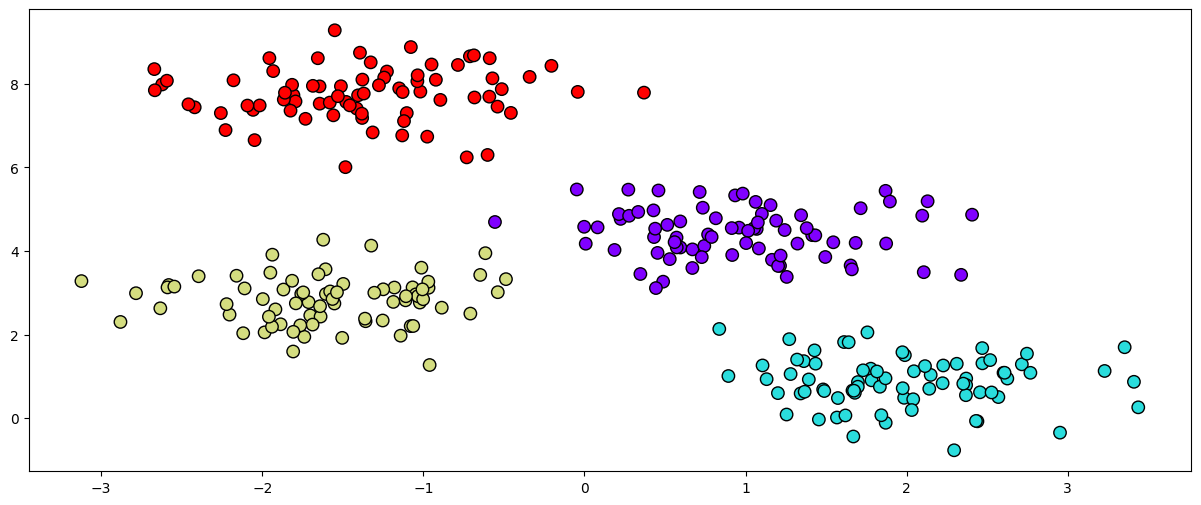

In [75]:
X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=0.60)

fig, ax = plt.subplots()

ax.scatter(X[:, 0], X[:, 1], c=y, s=80, cmap=CMAP, edgecolors='black')

plt.show()

Decision Trees have a number of tunable parameters. 

class sklearn.tree.DecisionTreeClassifier(**criterion**='gini', splitter='best', **max_depth**=None, **min_samples_split**=2, **min_samples_leaf**=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, class_weight=None, presort=False)

Parameters of interest are marked in bold.

In [76]:
clf = DecisionTreeClassifier(max_depth=10)
clf.fit(X,y)

DecisionTreeClassifier(max_depth=10)

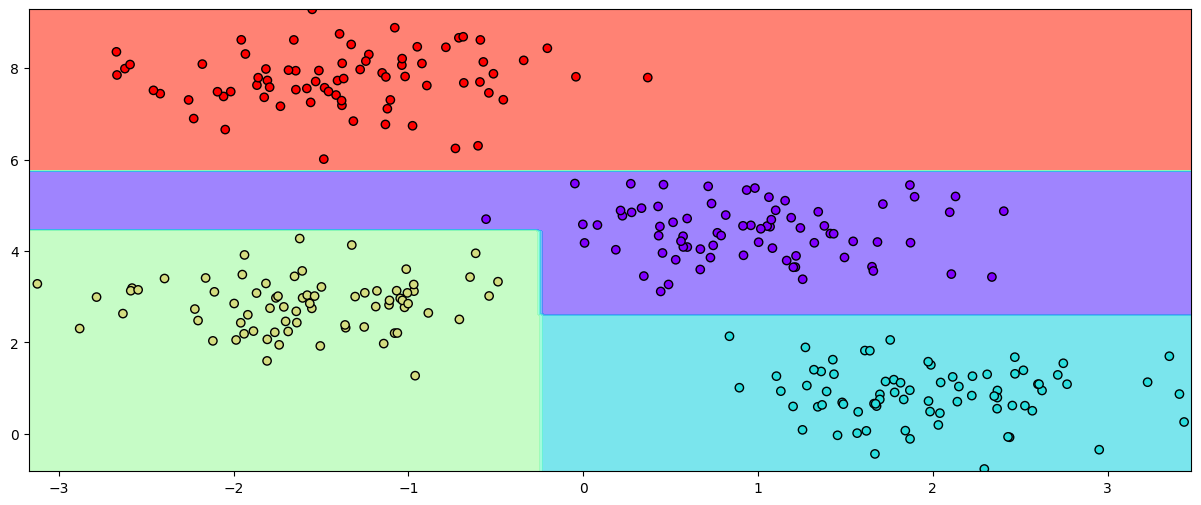

In [77]:
fn_plot_decision_boundary(clf, X, y)

### Controlling complexity of decision trees

In [78]:
data = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(
    data.data, 
    data.target, 
    stratify=data.target, 
    random_state=RANDOM_STATE)

tree = DecisionTreeClassifier(random_state=RANDOM_STATE)

tree.fit(X_train, y_train)

print("Accuracy on train set: {:.3f}".format(tree.score(X_train, y_train)))

print("Accuracy on test set : {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on train set: 1.000
Accuracy on test set : 0.895


In [79]:
tree = DecisionTreeClassifier(max_depth=3, 
                              random_state=RANDOM_STATE)

tree.fit(X_train, y_train)

print("Accuracy on train set: {:.3f}".format(tree.score(X_train, y_train)))

print("Accuracy on test set : {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on train set: 0.984
Accuracy on test set : 0.902


In [80]:

export_graphviz(tree, out_file="images/tree.dot", class_names=["malignant", "benign"],
                feature_names=data.feature_names, impurity=False, filled=True)

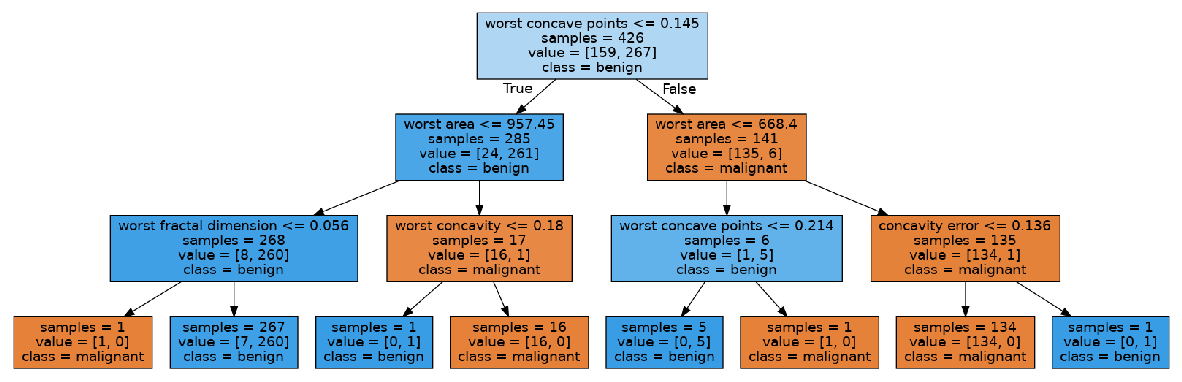

In [81]:
import graphviz

with open("images/tree.dot") as f:
    dot_graph = f.read()
img = graphviz.Source(dot_graph)
! dot -Tpng images/tree.dot -o images/tree.png
fig, ax = plt.subplots()
ax.axis('off')
ax.imshow(mpimg.imread("images/tree.png"));

In [82]:
# feature importance considering full depth

tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
tree.fit(X_train, y_train)
print("Feature importances:")

print(tree.feature_importances_)


Feature importances:
[0.         0.02218621 0.         0.         0.00836219 0.
 0.         0.00877635 0.         0.         0.         0.00448918
 0.         0.         0.0080277  0.         0.         0.0080277
 0.00501731 0.00188391 0.         0.00999246 0.         0.17254873
 0.0099603  0.         0.00944435 0.72180374 0.         0.00947986]


(-1.0, 30.0)

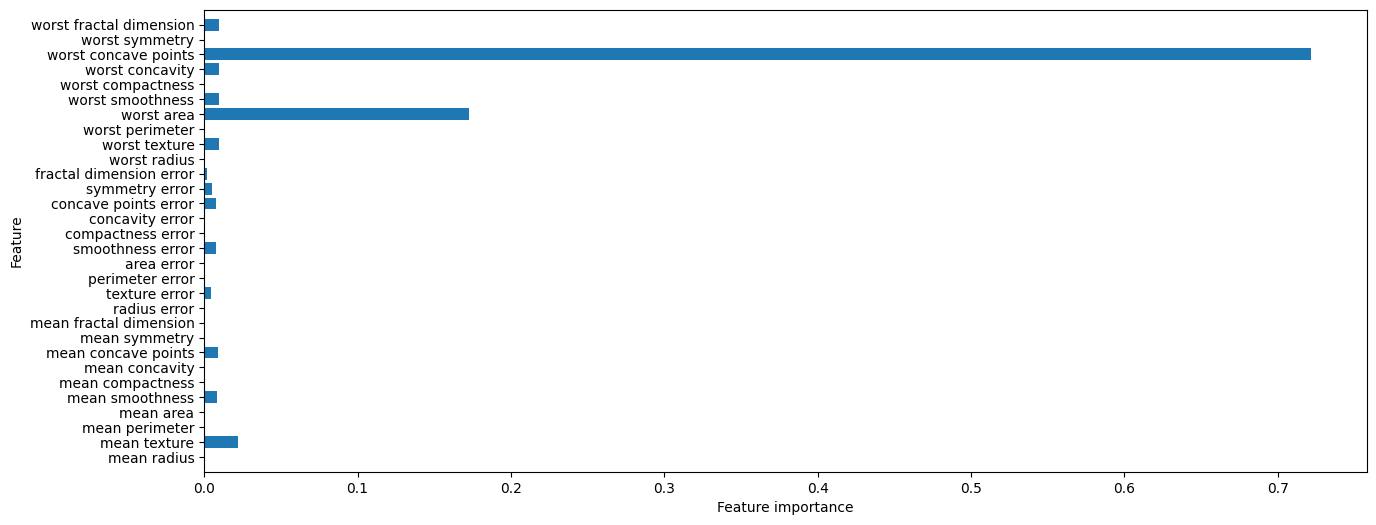

In [83]:
n_features = data.data.shape[1]

plt.barh(np.arange(n_features), 
         tree.feature_importances_, 
         align='center')

plt.yticks(np.arange(n_features), data.feature_names)

plt.xlabel("Feature importance")

plt.ylabel("Feature")

plt.ylim(-1, n_features)

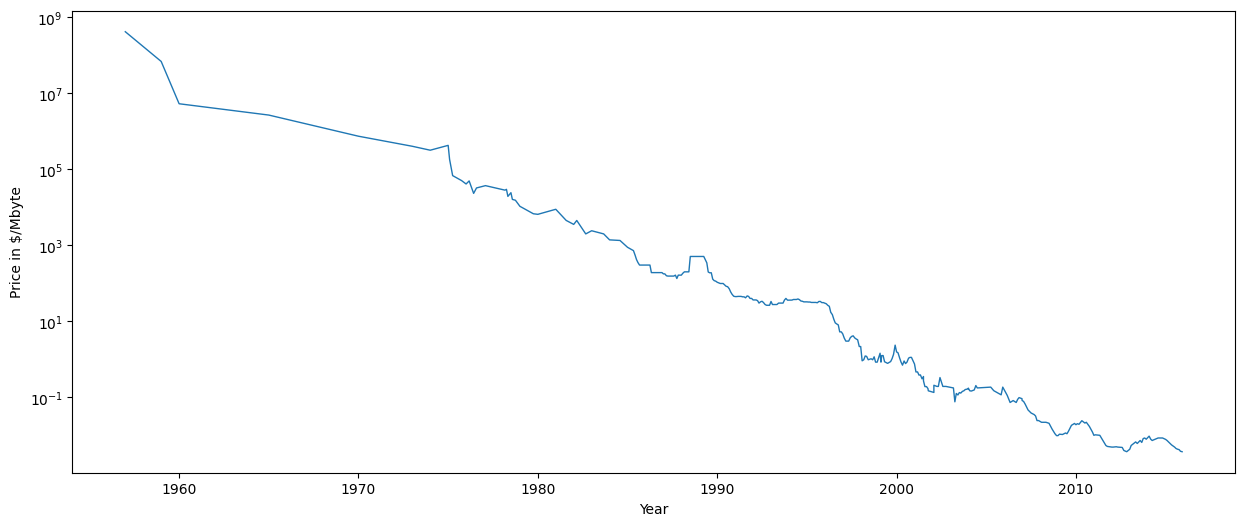

In [84]:
ram_prices = pd.read_csv(os.path.join(inpDir, moduleDir,"ram_price.csv"))

fig, ax = plt.subplots()

ax.semilogy(ram_prices.date, ram_prices.price)
ax.set_xlabel("Year")
ax.set_ylabel("Price in $/Mbyte")
plt.show()

## Decision Tree Regressor

In [85]:

# use historical data to forecast prices after the year 2000
data_train = ram_prices[ram_prices.date < 2000]
data_test = ram_prices[ram_prices.date >= 2000]

# predict prices based on date
X_train = data_train.date.to_numpy()[:, np.newaxis]

# we use a log-transform to get a simpler relationship of data to target
y_train = np.log(data_train.price)

tree = DecisionTreeRegressor(max_depth=3).fit(X_train, y_train)

linear_reg = LinearRegression().fit(X_train, y_train)

# predict on all data
X_all = ram_prices.date.to_numpy()[:, np.newaxis]

pred_tree = tree.predict(X_all)

pred_lr = linear_reg.predict(X_all)

# undo log-transform
price_tree = np.exp(pred_tree)

price_lr = np.exp(pred_lr)

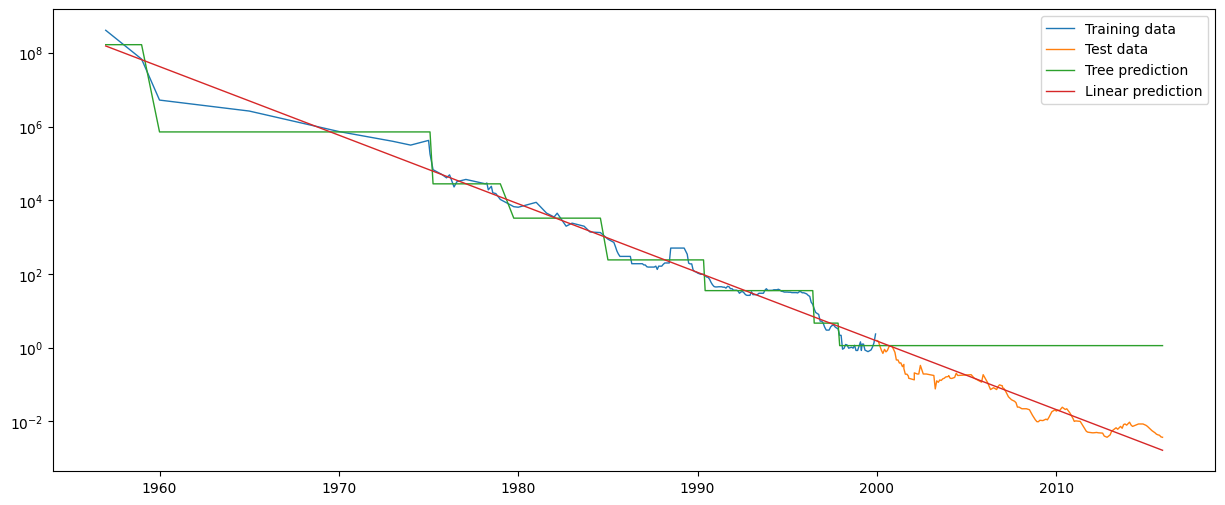

In [86]:
fig, ax = plt.subplots()

ax.semilogy(data_train.date, data_train.price, label="Training data")

ax.semilogy(data_test.date, data_test.price, label="Test data")

ax.semilogy(ram_prices.date, price_tree, label="Tree prediction")

ax.semilogy(ram_prices.date, price_lr, label="Linear prediction")

plt.legend();

## Random Forests

One problem with decision trees is that they can end up **over-fitting** the data. They are such flexible models that, given a large depth, they can quickly memorize the inputs, which doesn't generalize well to previously unseen data. One way to get around this is to use many slightly different decision trees in concert. This is known as **Random Forests**, and is one of the more common techniques of **ensemble learning** (i.e. combining the results from several estimators.

<img src = '../../images/ensamble.jpg' alt='Ensamble and Random forest' />

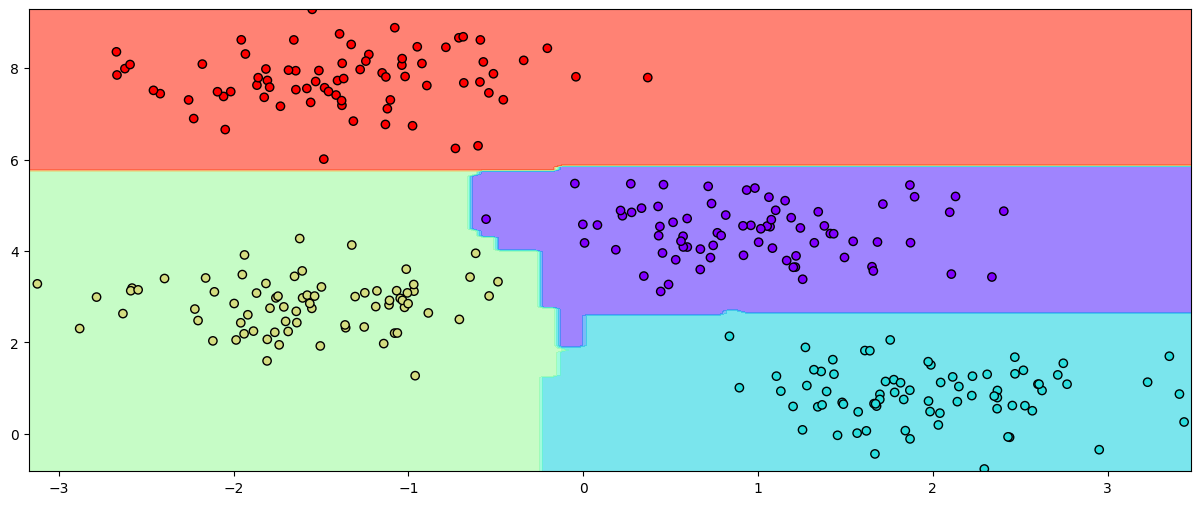

In [87]:
clf = RandomForestClassifier(n_estimators=10, random_state=0)

clf.fit(X,y)

fn_plot_decision_boundary(clf, X, y)

It's difficult to see in this example, but for more complicated data, random forests can be a very powerful technique.

### Classifying Digits

Lets work on digits dataset... its good time to check efficacy of RandomForest

In [88]:
digits = load_digits()

digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [89]:
X = digits.data

y = digits.target

print(X.shape)

print(y.shape)

(1797, 64)
(1797,)


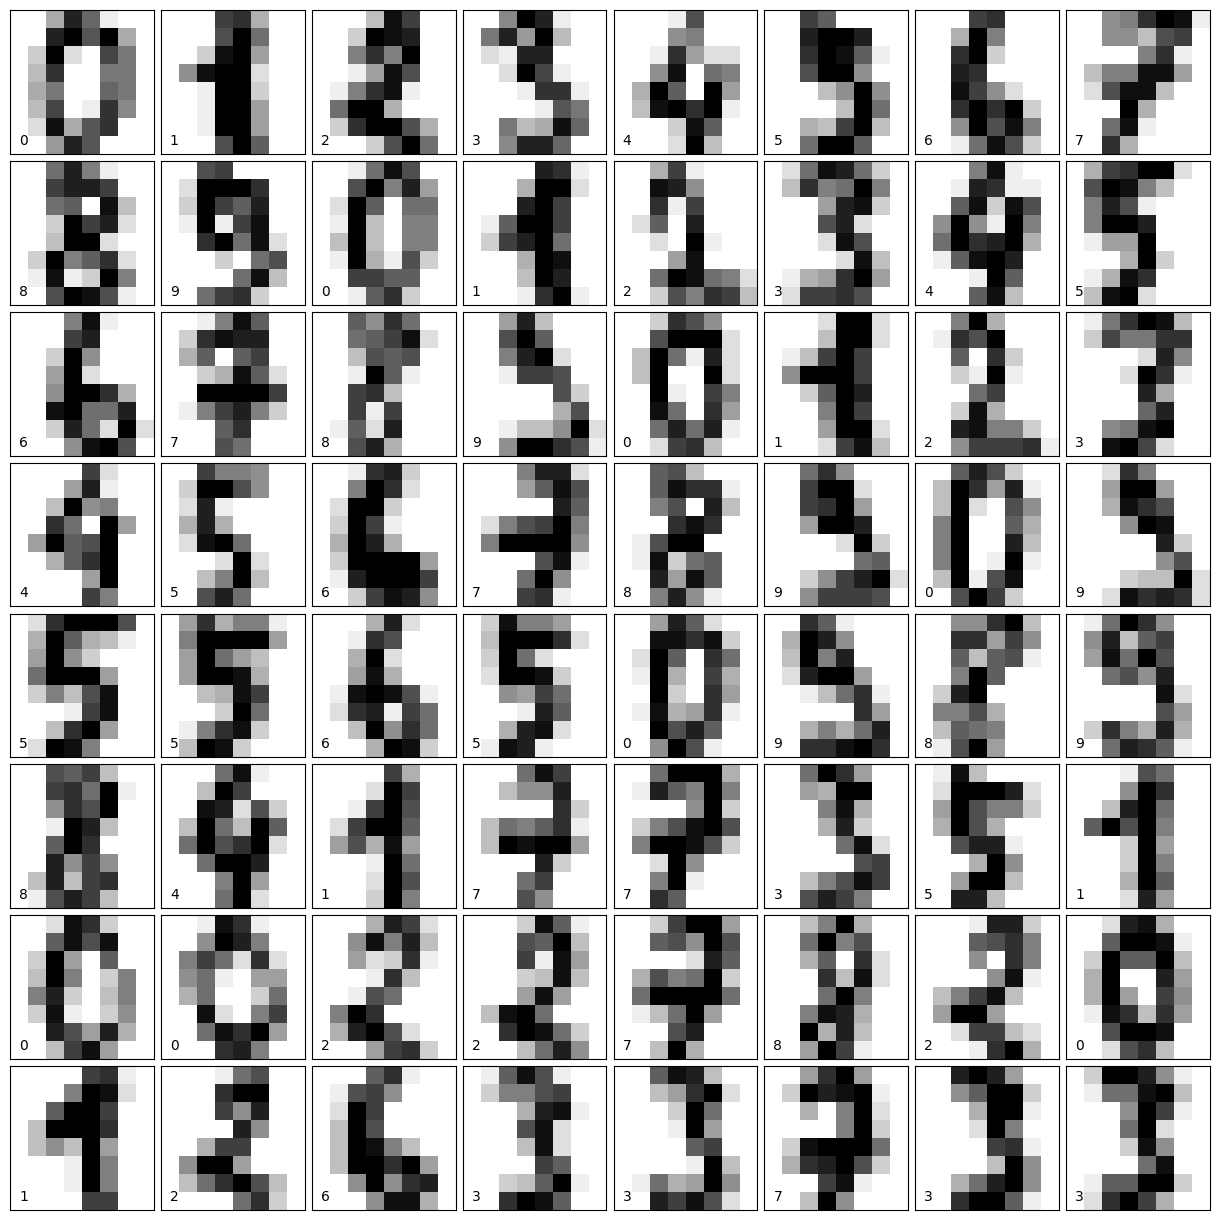

In [90]:
# set up the figure
fig = plt.figure(figsize=(12, 12))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

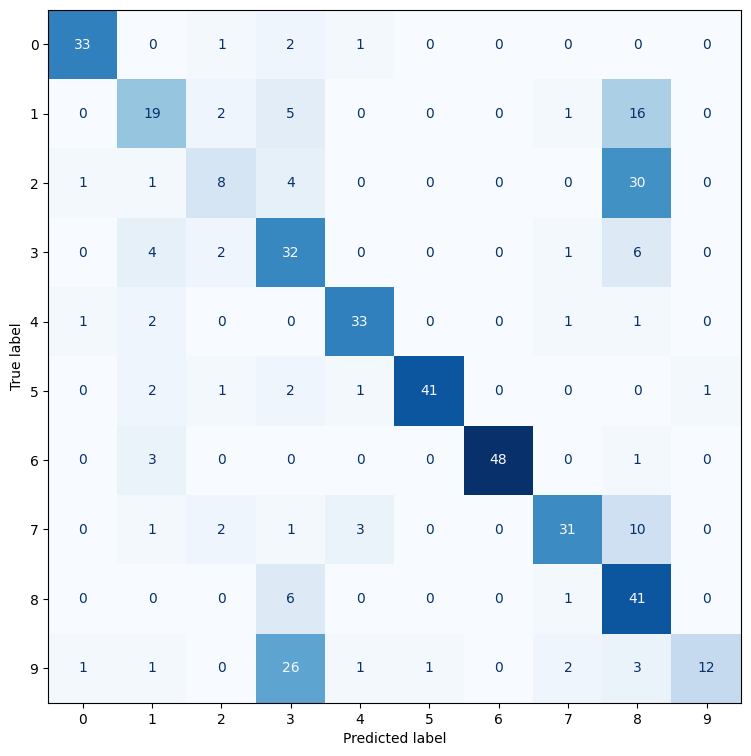

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = DecisionTreeClassifier(max_depth=5)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)


cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=digits.target_names)

fig, ax = plt.subplots(figsize = (9,9))

disp.plot(ax = ax, cmap=plt.cm.Blues, colorbar=False);

ax.grid(False)

RF: max_depth =   3 | F1 Score :  0.8707
RF: max_depth =   5 | F1 Score :  0.9378
RF: max_depth =  10 | F1 Score :  0.9756


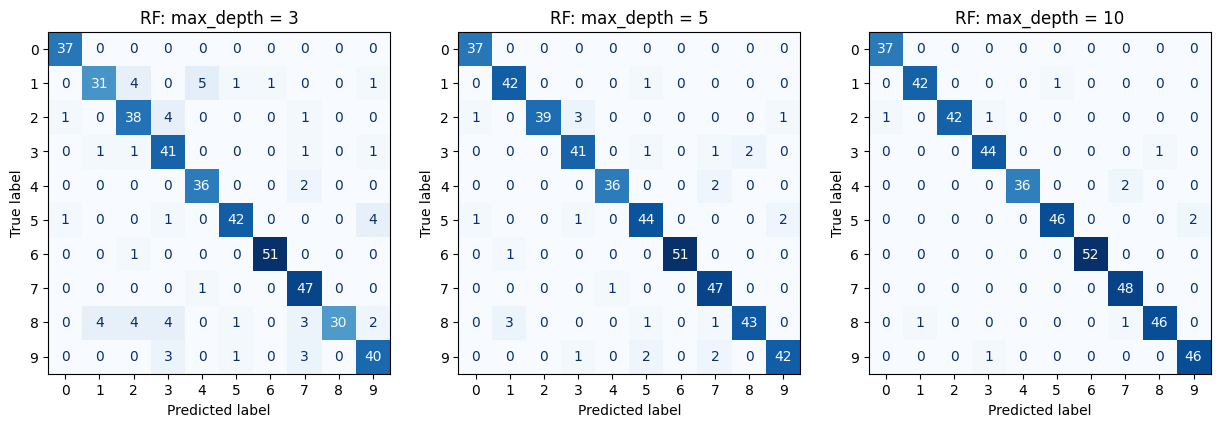

In [92]:
# random forest results
fig, axes = plt.subplots(1,3, figsize = (15,8))
for i, max_depth in enumerate([3, 5, 10]):
    clf = RandomForestClassifier(max_depth=max_depth).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("RF: max_depth = {:3d}".format(max_depth), end = ' | ')
    print("F1 Score : {: .4f}".format(f1_score(y_test, y_pred, average='weighted')))
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=digits.target_names)

    disp.plot(ax = axes[i], cmap=plt.cm.Blues, colorbar=False);
    axes[i].set_title("RF: max_depth = {0}".format(max_depth))
    axes[i].grid(False)

## K Neighbors Classifier

Loading Iris dataset

In [93]:
iris = load_iris()

iris.data.shape

(150, 4)

<img src='../../images/iris.png' style = 'width:600px;' alt="iris images" align="left"/>

<img src='../../images/iris_petal_sepal.png' style = 'width:250px;' alt="iris images" align="left"/>

In [94]:
n_samples, n_features = iris.data.shape
print (n_samples, n_features)
print( iris.data[0])

150 4
[5.1 3.5 1.4 0.2]


In [95]:
from sklearn.neighbors import KNeighborsClassifier

X, y = iris.data, iris.target

# get the label Names as well
target_names = iris.target_names


clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X, y)
y_pred = clf.predict(X)
print(np.all(y == y_pred))

True


In [96]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y, y_pred))

[[50  0  0]
 [ 0 50  0]
 [ 0  0 50]]


In [97]:
# helper function
from sklearn.metrics import euclidean_distances

def plot_knn_classification(X_train, y_train, X_test, n_neighbors=1):
    
    dist = euclidean_distances(X_train, X_test)
    closest = np.argsort(dist, axis=0)

    for x, neighbors in zip(X_test, closest.T):
        for neighbor in neighbors[:n_neighbors]:
            plt.arrow(x[0], x[1], X[neighbor, 0] - x[0],
                      X[neighbor, 1] - x[1], head_width=0, fc='k', ec='k')

    clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train, y_train)
    plt.scatter(X_test[:,0], X_test[:,1], s=30, c=clf.predict(X_test), marker = '*', cmap=CMAP)
    plt.scatter(X_train[:,0], X_train[:,1], s=30, c=y_train, marker = 'o', cmap=CMAP)

    #test_points = discrete_scatter(X_test[:, 0], X_test[:, 1], clf.predict(X_test), markers="*")
    #training_points = discrete_scatter(X[:, 0], X[:, 1], y)
    plt.legend(training_points + test_points, ["training class 0", "training class 1",
                                               "test pred 0", "test pred 1"])

### A better representation

In [98]:
from sklearn.model_selection import train_test_split


#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(112, 4) (112,) (38, 4) (38,)


In [99]:
from sklearn.preprocessing import StandardScaler

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# scale our data
sc = StandardScaler()

###--------------------------------
### always:
###   fit_transform train data and
###   transform only test data
###-------------------------------

X_s_train = sc.fit_transform(X_train)
X_s_test = sc.transform(X_test)    

lda = LinearDiscriminantAnalysis(n_components=2)
X_train2 = lda.fit_transform(X_s_train, y_train)
X_test2 = lda.transform(X_s_test)

In [100]:
n_neighbors = 1

clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train2, y_train)
y_pred = clf.predict(X_test2)

In [101]:
dist = euclidean_distances(X_train2, X_test2)
closest = np.argsort(dist, axis=0)

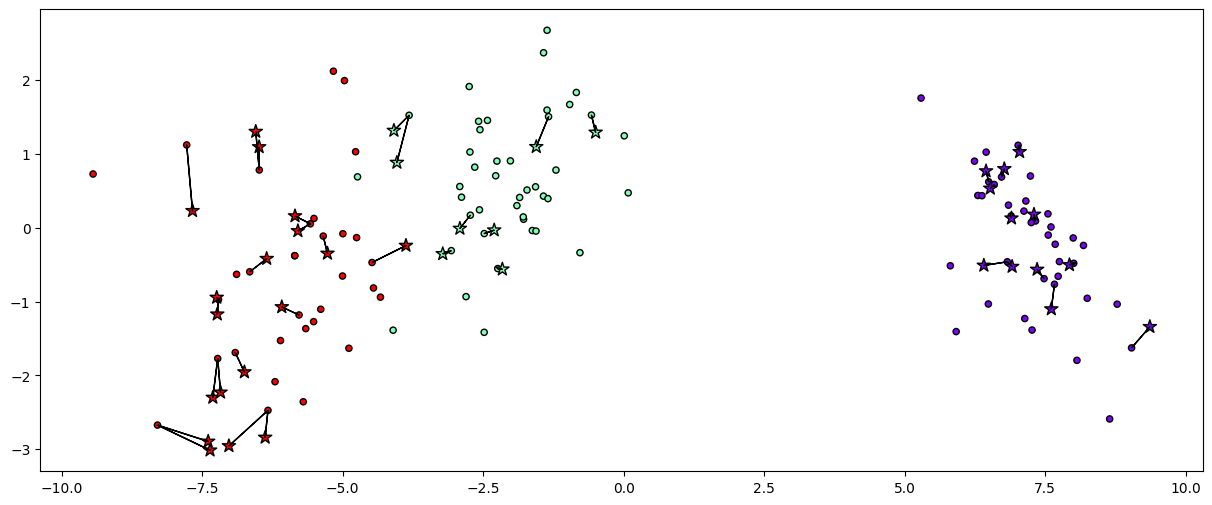

In [102]:
# Lets Plot the data
plt.scatter(X_train2[:,0], X_train2[:,1], s=20, c=y_train, cmap = CMAP, edgecolors='k')
plt.scatter(X_test2[:,0], X_test2[:,1], s=100, marker ='*', c=y_pred, edgecolors='k', cmap = CMAP)
for x, neighbors in zip(X_test2, closest.T):
    for neighbor in neighbors[:n_neighbors]:
        plt.arrow(x[0], x[1], X_train2[neighbor, 0] - x[0],
                  X_train2[neighbor, 1] - x[1], head_width=0, fc='k', ec='k')

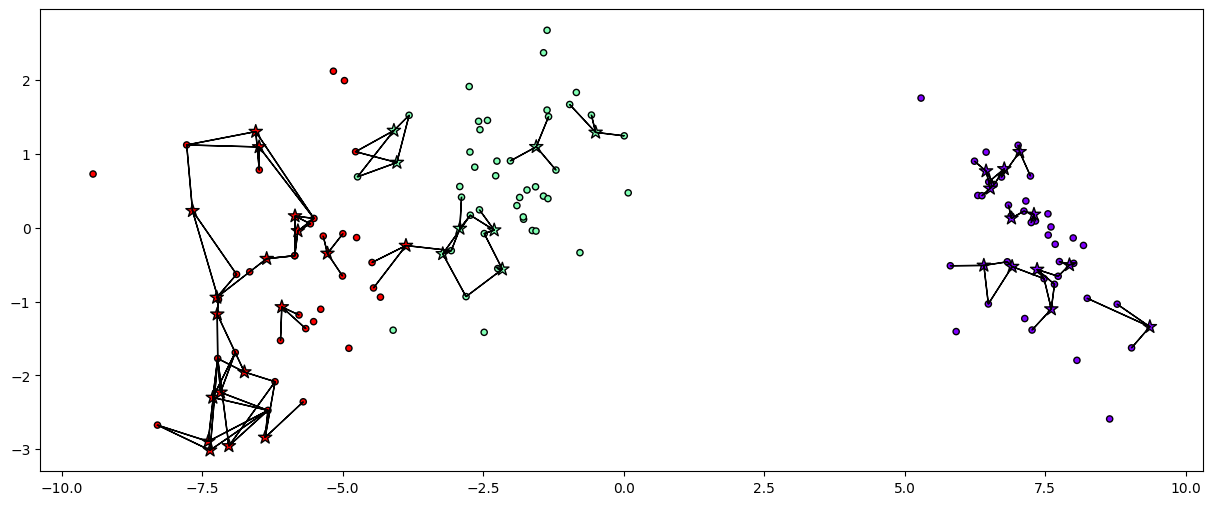

In [103]:
n_neighbors = 3

clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train2, y_train)
y_pred = clf.predict(X_test2)

# Lets Plot the data
plt.scatter(X_train2[:,0], X_train2[:,1], s=20, c=y_train, cmap = CMAP, edgecolors='k')
plt.scatter(X_test2[:,0], X_test2[:,1], s=100, marker ='*', c=y_pred, edgecolors='k', cmap = CMAP)
for x, neighbors in zip(X_test2, closest.T):
    for neighbor in neighbors[:n_neighbors]:
        plt.arrow(x[0], x[1], X_train2[neighbor, 0] - x[0],
                  X_train2[neighbor, 1] - x[1], head_width=0, fc='k', ec='k')

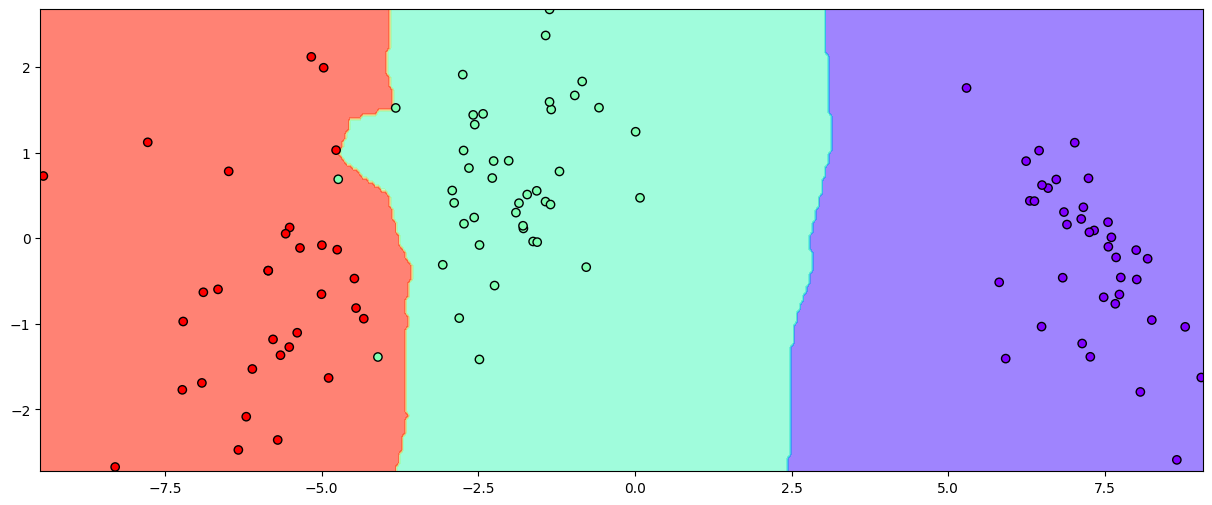

In [104]:
fn_plot_decision_boundary(clf, X_train2, y_train)

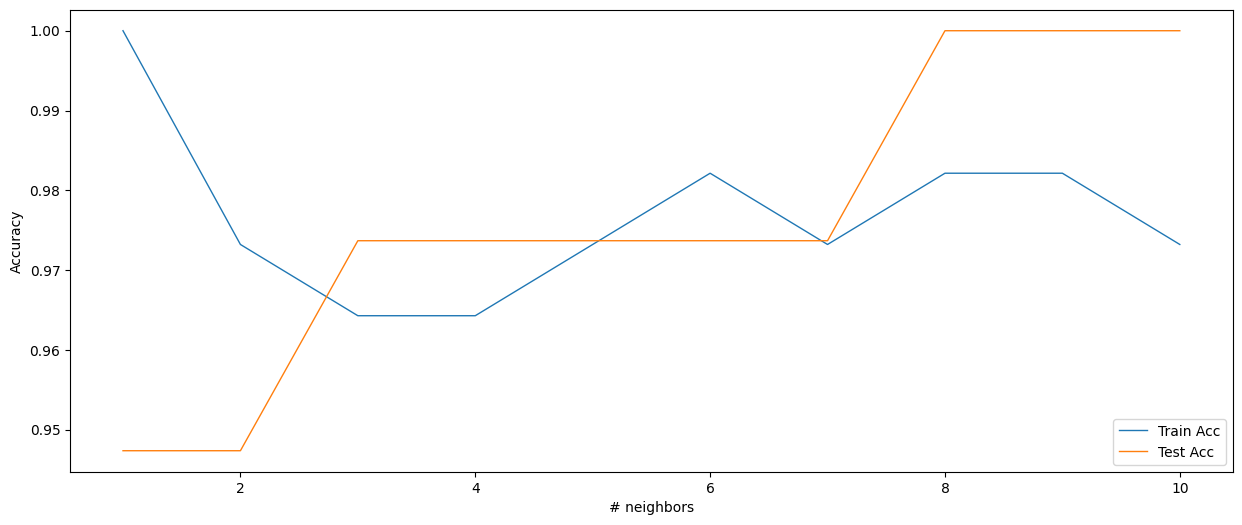

In [105]:
training_accuracy = []
test_accuracy = []

# try n_neighbors from 1 to 10

for n_neighbors in range(1, 11):
    # build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))

fig, ax = plt.subplots()
ax.plot(range(1, 11), training_accuracy, label="Train Acc")
ax.plot(range(1, 11), test_accuracy, label="Test Acc")
ax.set_ylabel("Accuracy")
ax.set_xlabel("# neighbors")
ax.legend();

## SGD Classifier

Linear classifiers (SVM, logistic regression, etc.) with SGD training.

This estimator implements regularized linear models with **Stochastic Gradient Descent (SGD)** learning: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule (aka learning rate). SGD allows minibatch (online/out-of-core) learning via the partial_fit method. For best results using the default learning rate schedule, the data should have zero mean and unit variance.

This implementation works with data represented as dense or sparse arrays of floating point values for the features. The model it fits can be controlled with the loss parameter; by default, it fits a linear support vector machine (SVM).

Loss function decides what alcorithm to us.

- `hinge` gives a linear SVM.
- `log_loss` gives logistic regression, a probabilistic classifier.
- `modified_huber` is another smooth loss that brings tolerance to outliers as well as probability estimates.
- `squared_hinge` is like hinge but is quadratically penalized.
- `perceptron` is the linear loss used by the perceptron algorithm.

The other losses, `squared_error`, `huber`, `epsilon_insensitive` and `squared_epsilon_insensitive` are designed for regression but can be useful in classification as well.

The regularizer is a penalty added to the loss function that shrinks model parameters towards the zero vector using either the squared euclidean norm L2 or the absolute norm L1 or a combination of both (Elastic Net). If the parameter update crosses the 0.0 value because of the regularizer, the update is truncated to 0.0 to allow for learning sparse models and achieve online feature selection.

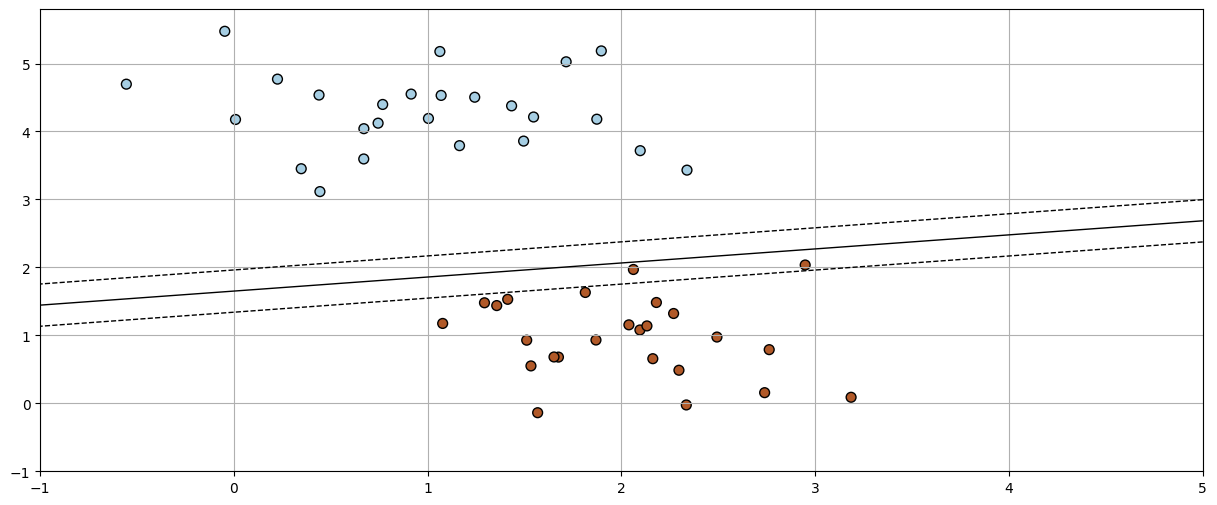

In [107]:

from sklearn.linear_model import SGDClassifier
from sklearn.datasets import make_blobs

# we create 50 separable points
X, Y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.60)

# fit the model
clf = SGDClassifier(loss="hinge", alpha=0.01, max_iter=200)

clf.fit(X, Y)

# plot the line, the points, and the nearest vectors to the plane
xx = np.linspace(-1, 5, 10)
yy = np.linspace(-1, 5, 10)

X1, X2 = np.meshgrid(xx, yy)
Z = np.empty(X1.shape)
for (i, j), val in np.ndenumerate(X1):
    x1 = val
    x2 = X2[i, j]
    p = clf.decision_function([[x1, x2]])
    Z[i, j] = p[0]
levels = [-1.0, 0.0, 1.0]

linestyles = ["dashed", "solid", "dashed"]

colors = "k"

plt.contour(X1, X2, Z, levels, colors=colors, linestyles=linestyles)

plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired, edgecolor="black", s=50)

plt.axis("tight")

plt.grid(True)

plt.show()